In [663]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.metrics import (classification_report, confusion_matrix, 
                           ConfusionMatrixDisplay, roc_auc_score, 
                           make_scorer, f1_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from IPython.display import display

In [664]:
# Create a models directory if it doesn't exist
MODEL_DIR = "saved_models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

In [665]:
# =============================================================================
# Data Loading and Preprocessing
# =============================================================================
file_path = 'Synthetic_Financial_datasets_log.csv'
df = pd.read_csv(file_path, low_memory=False)

In [666]:
# Display basic info
print("Data shape:", df.shape)
display(df.head())

Data shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.6400",C1231006815,"170,136.0000","160,296.3600",M1979787155,0.0000,0.0000,0,0
1,1,PAYMENT,"1,864.2800",C1666544295,"21,249.0000","19,384.7200",M2044282225,0.0000,0.0000,0,0
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,CASH_OUT,181.0000,C840083671,181.0000,0.0000,C38997010,"21,182.0000",0.0000,1,0
4,1,PAYMENT,"11,668.1400",C2048537720,"41,554.0000","29,885.8600",M1230701703,0.0000,0.0000,0,0


In [667]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000"
mean,243.3972,"179,861.9035","833,883.1041","855,113.6686","1,100,701.6665","1,224,996.3982",0.0013,0.0000
std,142.3320,"603,858.2315","2,888,242.6730","2,924,048.5030","3,399,180.1130","3,674,128.9421",0.0359,0.0016
min,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,156.0000,"13,389.5700",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,239.0000,"74,871.9400","14,208.0000",0.0000,"132,705.6650","214,661.4400",0.0000,0.0000
75%,335.0000,"208,721.4775","107,315.1750","144,258.4100","943,036.7075","1,111,909.2500",0.0000,0.0000
max,743.0000,"92,445,516.6400","59,585,040.3700","49,585,040.3700","356,015,889.3500","356,179,278.9200",1.0000,1.0000


# DELETING 100% NULL NUMERIC COLUMNS

In [668]:
nan_col = []
for i in df.columns:
  if df[i].dtype == 'float64' and df[i].describe()['count'] == 0.0:
    nan_col.append(i)
# nan_col # NAN numeric columns

In [669]:
#Drop 81 NAN numeric columns
df.drop(nan_col, axis=1, inplace=True)
print(f"Dropped {len(nan_col)} null columns")

Dropped 0 null columns


In [670]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.6400",C1231006815,"170,136.0000","160,296.3600",M1979787155,0.0000,0.0000,0,0
1,1,PAYMENT,"1,864.2800",C1666544295,"21,249.0000","19,384.7200",M2044282225,0.0000,0.0000,0,0
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,CASH_OUT,181.0000,C840083671,181.0000,0.0000,C38997010,"21,182.0000",0.0000,1,0
4,1,PAYMENT,"11,668.1400",C2048537720,"41,554.0000","29,885.8600",M1230701703,0.0000,0.0000,0,0


In [671]:
df.shape

(6362620, 11)

# Deleting columns with only 1 value
because there will not be contributing in decision making

In [672]:
unique1_col = []
for i in df.columns:
  if df[i].nunique() == 1:
    unique1_col.append(i)
unique1_col # Having 1 unique columns

[]

In [673]:
#Drop unique 1 value columns
df.drop(unique1_col, axis=1, inplace=True)
print(f"Dropped {len(unique1_col)} single-value columns")
df.shape

Dropped 0 single-value columns


(6362620, 11)

# Deleting NULL values columns other than numeric

In [674]:
null90_col = []
for i in df.columns:
  if df[i].isnull().sum() * 100 / df.shape[0] >= 90.0:
    null90_col.append(i)
null90_col # Having 90% null columns

[]

In [675]:
#Drop 90% null value columns
df.drop(null90_col, axis=1, inplace=True)
print(f"Dropped {len(null90_col)} 90%-null columns")
df.shape

Dropped 0 90%-null columns


(6362620, 11)

In [676]:
# Data Exploration Functions (Same as before)
def stats_generate(df):
    stats = []
    for col in df.columns:
        stats.append({
            'Column Name': col,
            'Unique_values': df[col].nunique(),
            'Percentage of NULL values': df[col].isnull().sum() * 100 / df.shape[0],
            'data type': df[col].dtype
        })
    return pd.DataFrame(stats)

In [677]:
def Catergories(df, col):
    print(f"--- {col} ---")
    print("Unique values:", df[col].unique())
    print("Null values:", df[col].isnull().sum())
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.ylabel('Count')
    plt.show()

In [678]:
Generated_Stats = stats_generate(df)
Generated_Stats.head(50)

,Column Name,Unique_values,Percentage of NULL values,data type
0,step,743,0.0000,int64
1,type,5,0.0000,object
2,amount,5316900,0.0000,float64
3,nameOrig,6353307,0.0000,object
4,oldbalanceOrg,1845844,0.0000,float64
5,newbalanceOrig,2682586,0.0000,float64
6,nameDest,2722362,0.0000,object
7,oldbalanceDest,3614697,0.0000,float64
8,newbalanceDest,3555499,0.0000,float64
9,isFraud,2,0.0000,int64


There are:
11 columns without missing values
0 columns with less than 10% of missing values
 0 columns with missing values between 10% and 50%
 0 columns with more than 50% of missing values


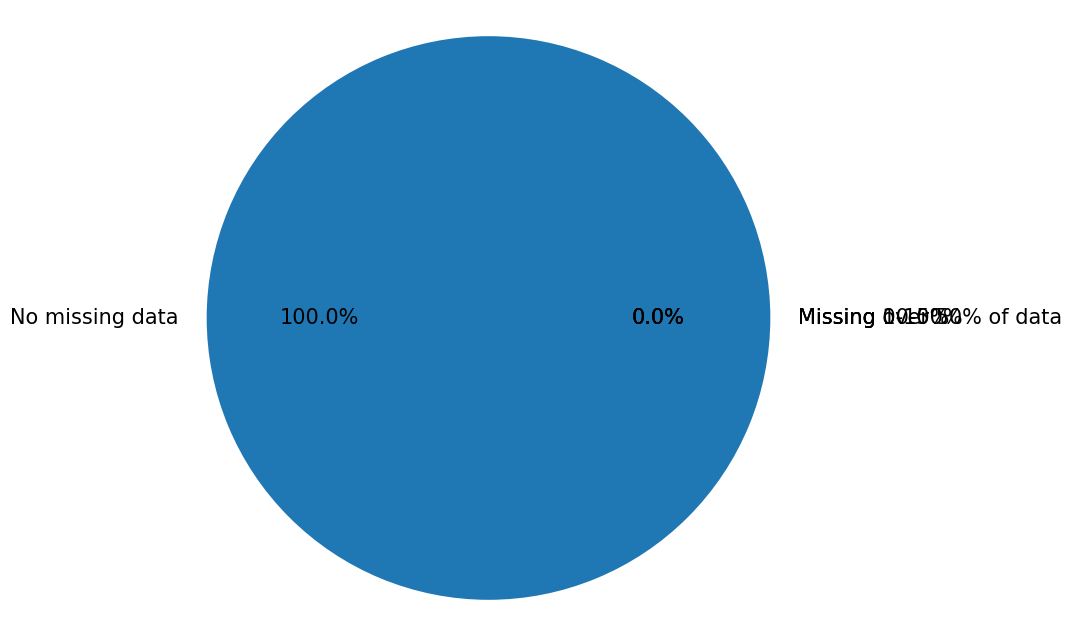

In [679]:
col= "Percentage of NULL values"
analysis = (Generated_Stats[col] <= 10).sum()
a = ((Generated_Stats[col]!=0) & (Generated_Stats[col]<=10)).sum()
b = ((Generated_Stats[col]>10) & (Generated_Stats[col]<=50)).sum()
c = (Generated_Stats[col]>50).sum()
print("There are:\n{} columns without missing values\n{} columns with less than 10% of missing values\n {} columns with missing values between 10% and 50%\n {} columns with more than 50% of missing values".format(analysis,a,b,c))

labels =["No missing data", "Missing 0-10%", "Missing 10-50%", "Missing over 50% of data"]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie([analysis,a,b,c], autopct='%1.1f%%',labels=labels, textprops={'fontsize': 15})
ax1.axis('equal')
plt.show()

In [680]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.6400",C1231006815,"170,136.0000","160,296.3600",M1979787155,0.0000,0.0000,0,0
1,1,PAYMENT,"1,864.2800",C1666544295,"21,249.0000","19,384.7200",M2044282225,0.0000,0.0000,0,0
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,CASH_OUT,181.0000,C840083671,181.0000,0.0000,C38997010,"21,182.0000",0.0000,1,0
4,1,PAYMENT,"11,668.1400",C2048537720,"41,554.0000","29,885.8600",M1230701703,0.0000,0.0000,0,0


In [681]:
df.shape

(6362620, 11)

--- type ---
Unique values: ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
Null values: 0


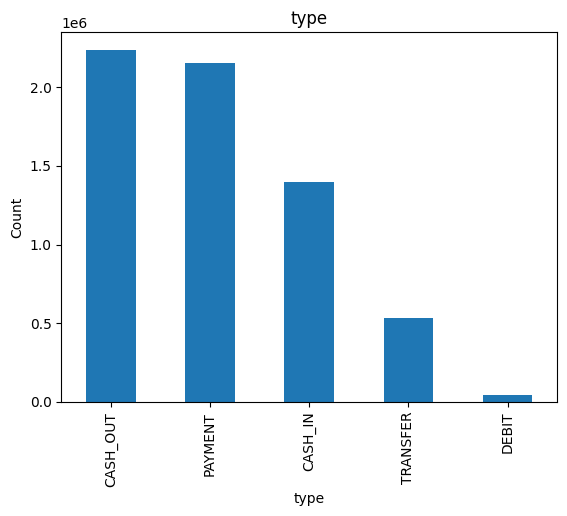

In [682]:
Catergories(df,'type')

--- step ---
Unique values: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 24

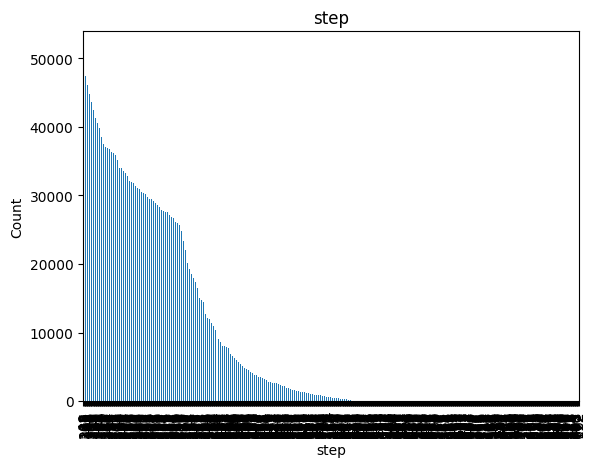

In [683]:
Catergories(df,'step')

--- isFraud ---
Unique values: [0 1]
Null values: 0


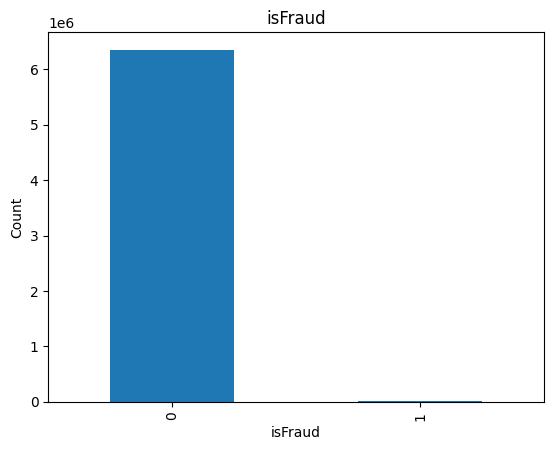

In [684]:
Catergories(df,'isFraud')

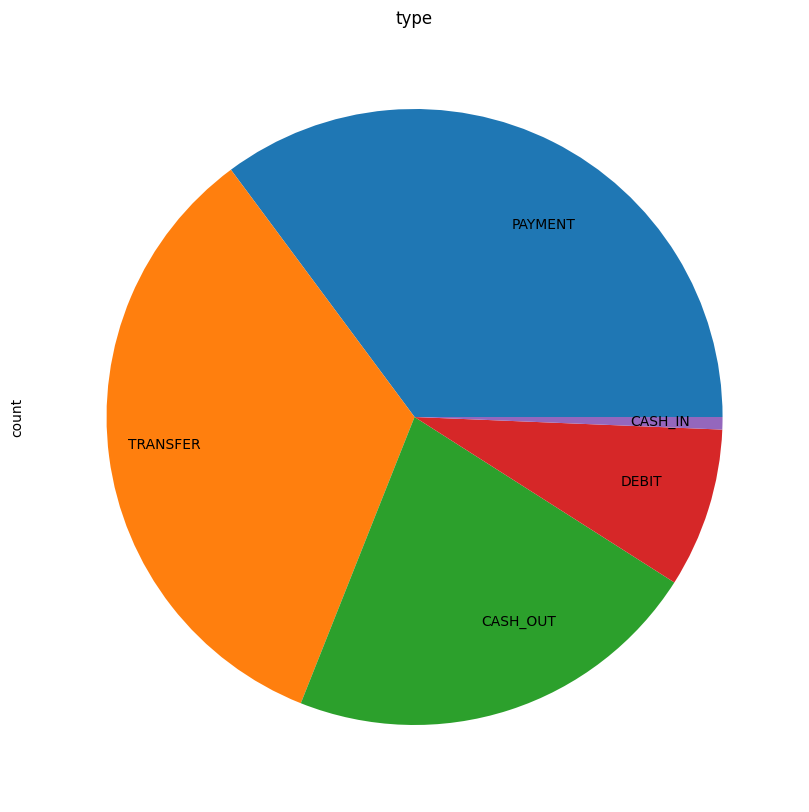

In [685]:
col = 'type'
df[col].value_counts().plot.pie(labels= df[col].unique() , labeldistance = 0.7,figsize=(10, 10))
plt.title(col)
plt.show()

In [686]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.6400",C1231006815,"170,136.0000","160,296.3600",M1979787155,0.0000,0.0000,0,0
1,1,PAYMENT,"1,864.2800",C1666544295,"21,249.0000","19,384.7200",M2044282225,0.0000,0.0000,0,0
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,CASH_OUT,181.0000,C840083671,181.0000,0.0000,C38997010,"21,182.0000",0.0000,1,0
4,1,PAYMENT,"11,668.1400",C2048537720,"41,554.0000","29,885.8600",M1230701703,0.0000,0.0000,0,0


In [687]:
def convertToCat(df,col):
  df[col] = df[col].astype('category')
  df[col]= df[col].cat.codes

In [688]:
categorical_Col= ['type']
for i in categorical_Col:
  convertToCat(df,i)

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,"9,839.6400",C1231006815,"170,136.0000","160,296.3600",M1979787155,0.0000,0.0000,0,0
1,1,3,"1,864.2800",C1666544295,"21,249.0000","19,384.7200",M2044282225,0.0000,0.0000,0,0
2,1,4,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,1,181.0000,C840083671,181.0000,0.0000,C38997010,"21,182.0000",0.0000,1,0
4,1,3,"11,668.1400",C2048537720,"41,554.0000","29,885.8600",M1230701703,0.0000,0.0000,0,0


In [689]:
df.shape

(6362620, 11)

In [690]:
def correlation(col1,col2,col3):
  sns.heatmap(df[[col1,col2,col3]].corr(method ='pearson'), cmap='RdBu_r', annot=True, center=0.5, vmin =0, vmax=1)
  plt.title('Correlation between' +' '+col1+ '~'+' '+ col2 +'columns\n')
  plt.show()

In [691]:
def correlation2(col1,col2):
  sns.heatmap(df[[col1,col2]].corr(method ='pearson'), cmap='RdBu_r', annot=True, center=0.5, vmin =0, vmax=1)
  plt.title('Correlation between' +' '+col1+ '~'+' '+ col2 +'columns\n')
  plt.show()

In [692]:
def correlation3(col1,col2,col3, col4):
  sns.heatmap(df[[col1,col2,col3, col4]].corr(method ='pearson'), cmap='RdBu_r', annot=True, center=0.5, vmin =0, vmax=1)
  plt.title('Correlation between' +' '+col1+ '~'+' '+ col2 +'columns\n')
  plt.show()

In [693]:
df.drop(columns=["nameOrig", "nameDest"], inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,"9,839.6400","170,136.0000","160,296.3600",0.0000,0.0000,0,0
1,1,3,"1,864.2800","21,249.0000","19,384.7200",0.0000,0.0000,0,0
2,1,4,181.0000,181.0000,0.0000,0.0000,0.0000,1,0
3,1,1,181.0000,181.0000,0.0000,"21,182.0000",0.0000,1,0
4,1,3,"11,668.1400","41,554.0000","29,885.8600",0.0000,0.0000,0,0


In [694]:
def get_skewwed_dataframe(df):
    pd.options.display.float_format = '{:,.4f}'.format
    sk_df = pd.DataFrame([{'column': c,
                          'uniq': df[c].nunique(),
                          'skewness': df[c].value_counts(normalize=True).values[0] * 100
                          } for c in df.columns])
    sk_df = sk_df.sort_values('skewness', ascending=False)
    return sk_df

In [695]:
_skewwed_data = get_skewwed_dataframe(df)

In [696]:
_skewwed_data.head(11)

,column,uniq,skewness
8,isFlaggedFraud,2,99.9997
7,isFraud,2,99.8709
4,newbalanceOrig,2682586,56.7308
5,oldbalanceDest,3614697,42.5043
6,newbalanceDest,3555499,38.3401
1,type,5,35.1663
3,oldbalanceOrg,1845844,33.0438
0,step,743,0.8071
2,amount,5316900,0.0504


In [697]:
# Fill nulls if any
df_model = df.fillna(0)

# 🎯 Features & Target
target = 'isFraud'
features = [col for col in df_model.columns if col != target]

X = df_model[features]
y = df_model[target]

# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 📊 Class Ratio Check
print("🔍 Class Distribution:")
print(y.value_counts(normalize=True))

🔍 Class Distribution:
isFraud
0   0.9987
1   0.0013
Name: proportion, dtype: float64


In [698]:
# 🧠 Custom F1 scorer
f1_scorer = make_scorer(f1_score)

# Initialize list to store all results
all_results = []

# Model Training & Hypertuning Function

In [699]:
# # =============================================================================
# # Model Training Functions with Persistence | GridSearchCV
# # =============================================================================
# def train_or_load_model(model_name, model, params, X_train, y_train, X_test, y_test):
#     """Train or load a model with persistence"""
#     model_path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    
#     if os.path.exists(model_path):
#         print(f"⏩ Loading pre-trained {model_name} model...")
#         model = joblib.load(model_path)
#         best_params = "Loaded from file"
#     else:
#         if params is None:
#             print(f"🛠️ Training {model_name} without GridSearchCV...")
#             model.fit(X_train, y_train)
#             best_params = "Default Params"
#         else:
#             print(f"🔍 Training {model_name} with GridSearchCV...")
#             grid = GridSearchCV(
#                 model,
#                 params,
#                 scoring=f1_scorer,
#                 cv=3,
#                 n_jobs=1,
#                 verbose=0
#             )
#             grid.fit(X_train, y_train)
#             model = grid.best_estimator_
#             best_params = grid.best_params_
            
#         joblib.dump(model, model_path)
#         print(f"💾 Saved {model_name} model")
    
#     # Evaluate
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
#     results = {
#         "Model": model_name,
#         "F1 Score": round(f1_score(y_test, y_pred), 4),
#         "ROC-AUC": round(roc_auc_score(y_test, y_proba), 4) if y_proba is not None else "N/A",
#         "Best Params": best_params,
#         "Trained Model": model
#     }
    
#     all_results.append(results)
#     display(pd.DataFrame([results]))
    
#     return model

In [700]:
# --- Define manual CV tuning function ---
def manual_cv_search_and_save(model_name, model_class, param_grid, X_train, y_train, X_test, y_test):
    """Manually loop through hyperparameter combinations, use CV to find best, and save."""
    model_path = os.path.join(MODEL_DIR, f"{model_name}.joblib")

    if os.path.exists(model_path):
        print(f"⏩ Loading pre-trained {model_name} model...")
        best_model = joblib.load(model_path)
    else:
        print(f"🔍 Performing manual CV for {model_name} with parameter combinations...")
        best_score = -1
        best_params = None
        best_model = None

        for params in ParameterGrid(param_grid):
            model = model_class(**params)
            cv_scores = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=5)
            avg_score = cv_scores.mean()
            print(f"Params: {params} → Avg F1: {avg_score:.4f}")
            if avg_score > best_score:
                best_score = avg_score
                best_params = params

        print(f"✅ Best params: {best_params} with F1: {best_score:.4f}")
        best_model = model_class(**best_params)
        best_model.fit(X_train, y_train)
        joblib.dump(best_model, model_path)
        print(f"💾 Saved {model_name} model")

    # Evaluate
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    results = {
        "Model": model_name,
        "F1 Score": round(f1_score(y_test, y_pred), 4),
        "ROC-AUC": round(roc_auc_score(y_test, y_proba), 4) if y_proba is not None else "N/A",
        "Best Params": best_model.get_params(),
        "Trained Model": best_model
    }
    all_results.append(results)
    display(pd.DataFrame([results]))
    return best_model

# Model: XGBoost

In [701]:
# =============================================================================
# XGBoost Model
# =============================================================================
print("\n" + "="*80)
print("🚀 XGBoost Evaluation")
print("="*80)

# =============================================================================
# GridSearchCV
# =============================================================================


# model_XGBoost = {
#     "model": XGBClassifier(eval_metric='logloss', random_state=42),
#     "params": {
#         "n_estimators": [100, 500],
#         "learning_rate": [0.01, 0.3],
#         "max_depth": [3, 10],
#         "subsample": [0.5, 1.0],
#         "colsample_bytree": [0.5, 1.0],
#         "scale_pos_weight": [1, 100]
#     }
# }

# xgb_model = train_or_load_model(
#     "XGBoost",
#     model_XGBoost["model"],
#     model_XGBoost["params"],
#     X_train, y_train, X_test, y_test
# )


# =============================================================================
# Only CV with Hyper paramount
# =============================================================================


xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

param_grid_xgb = {
    "n_estimators": [100, 500],
    "learning_rate": [0.01, 0.3],
    "max_depth": [3, 10],
    "subsample": [0.5, 1.0],
    "colsample_bytree": [0.5, 1.0],
    "scale_pos_weight": [1, 100]
}

xgb_model_manual = manual_cv_search_and_save(
    "XGBoost_ManualCV", 
    xgb_clf.__class__, 
    param_grid_xgb, 
    X_train, y_train, X_test, y_test
)



🚀 XGBoost Evaluation
⏩ Loading pre-trained XGBoost_ManualCV model...


,Model,F1 Score,ROC-AUC,Best Params,Trained Model
0,XGBoost_ManualCV,0.8984,0.9995,"{'objective': 'binary:logistic', 'base_score':...","XGBClassifier(base_score=None, booster=None, c..."


# Model: CatBoost

In [702]:
# =============================================================================
# CatBoost Model
# =============================================================================

# =============================================================================
# Only CV with Hyper paramount
# =============================================================================


cat_clf = CatBoostClassifier(verbose=0, random_state=42)

param_grid_cat = {
    "iterations": [100, 300],
    "learning_rate": [0.01, 0.1],
    "depth": [6, 10],
    "l2_leaf_reg": [1, 3]
}

cat_model_manual = manual_cv_search_and_save(
    "CatBoost_ManualCV", 
    cat_clf.__class__, 
    param_grid_cat, 
    X_train, y_train, X_test, y_test
)

⏩ Loading pre-trained CatBoost_ManualCV model...


,Model,F1 Score,ROC-AUC,Best Params,Trained Model
0,CatBoost_ManualCV,0.9021,0.9998,"{'iterations': 300, 'learning_rate': 0.1, 'dep...",<catboost.core.CatBoostClassifier object at 0x...


# Model: Light GBM

In [703]:
# =============================================================================
# LightGBM Model
# =============================================================================
print("\n" + "="*80)
print("🚀 LightGBM Evaluation")
print("="*80)

# =============================================================================
# GridSearchCV
# =============================================================================


# model_LightGBM = {
#     "model": LGBMClassifier(random_state=42),
#     "params": {
#         "n_estimators": [100, 500],
#         "learning_rate": [0.01, 0.3],
#         "max_depth": [3, 10],
#         "subsample": [0.5, 1.0],
#         "colsample_bytree": [0.5, 1.0],
#         "scale_pos_weight": [1, 100]
#     }
# }

# lgbm_model = train_or_load_model(
#     "LightGBM",
#     model_LightGBM["model"],
#     model_LightGBM["params"],
#     X_train, y_train, X_test, y_test
# )


# =============================================================================
# Only CV with Hyper paramount
# =============================================================================


lgbm_clf = LGBMClassifier(random_state=42)

param_grid_lgbm = {
    "n_estimators": [100, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [-1, 10],
    "subsample": [0.6, 1.0],
    "colsample_bytree": [0.6, 1.0]
}

lgbm_model_manual = manual_cv_search_and_save(
    "LightGBM_ManualCV", 
    lgbm_clf.__class__, 
    param_grid_lgbm, 
    X_train, y_train, X_test, y_test
)



🚀 LightGBM Evaluation
⏩ Loading pre-trained LightGBM_ManualCV model...


,Model,F1 Score,ROC-AUC,Best Params,Trained Model
0,LightGBM_ManualCV,0.5523,0.9228,"{'boosting_type': 'gbdt', 'class_weight': None...","LGBMClassifier(colsample_bytree=0.6, learning_..."


# Model: RandomForest

In [704]:
# =============================================================================
# RandomForest Model
# =============================================================================
print("\n" + "="*80)
print("🚀 RandomForest Evaluation")
print("="*80)

# =============================================================================
# GridSearchCV
# =============================================================================

# model_RandomForest = {
#     "model": RandomForestClassifier(random_state=42),
#     "params": {
#         "n_estimators": [100, 500],
#         "max_depth": [5, 20],
#         "max_features": ["sqrt", "log2"]
#     }
# }

# rf_model = train_or_load_model(
#     "RandomForest",
#     model_RandomForest["model"],
#     model_RandomForest["params"],
#     X_train, y_train, X_test, y_test
# )


# =============================================================================
# Only CV with Hyper paramount
# =============================================================================


rf_clf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "max_features": ['sqrt', 'log2']
}

rf_model_manual = manual_cv_search_and_save(
    "RandomForest_ManualCV", 
    rf_clf.__class__, 
    param_grid_rf, 
    X_train, y_train, X_test, y_test
)



🚀 RandomForest Evaluation
⏩ Loading pre-trained RandomForest_ManualCV model...


,Model,F1 Score,ROC-AUC,Best Params,Trained Model
0,RandomForest_ManualCV,0.8784,0.9978,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","(DecisionTreeClassifier(max_features='log2', r..."


# Model: GradientBoosting

In [ ]:
# =============================================================================
# GradientBoosting Model
# =============================================================================
print("\n" + "="*80)
print("🚀 GradientBoosting Evaluation")
print("="*80)

# =============================================================================
# GridSearchCV
# =============================================================================


# model_GradientBoosting = {
#     "model": GradientBoostingClassifier(random_state=42),
#     "params": {
#         "n_estimators": [100, 300],
#         "learning_rate": [0.01, 0.2],
#         "max_depth": [3, 10],
#         "subsample": [0.5, 1.0]
#     }
# }

# gb_model = train_or_load_model(
#     "GradientBoosting",
#     model_GradientBoosting["model"],
#     model_GradientBoosting["params"],
#     X_train, y_train, X_test, y_test
# )


# =============================================================================
# Only CV with Hyper paramount
# =============================================================================


gb_clf = GradientBoostingClassifier(random_state=42)

param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

gb_model_manual = manual_cv_search_and_save(
    "GradientBoosting_ManualCV", 
    gb_clf.__class__, 
    param_grid_gb, 
    X_train, y_train, X_test, y_test
)




🚀 GradientBoosting Evaluation
🔍 Performing manual CV for GradientBoosting_ManualCV with parameter combinations...
Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100} → Avg F1: 0.6234
Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200} → Avg F1: 0.5794
Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} → Avg F1: 0.6966


# Model: AdaBoost

In [ ]:
# =============================================================================
# AdaBoost Model
# =============================================================================
print("\n" + "="*80)
print("🚀 AdaBoost Evaluation")
print("="*80)

# =============================================================================
# GridSearchCV
# =============================================================================


# model_AdaBoost = {
#     "model": AdaBoostClassifier(random_state=42),
#     "params": {
#         "n_estimators": [50, 300],
#         "learning_rate": [0.01, 1.0]
#     }
# }

# ada_model = train_or_load_model(
#     "AdaBoost",
#     model_AdaBoost["model"],
#     model_AdaBoost["params"],
#     X_train, y_train, X_test, y_test
# )


# =============================================================================
# Only CV with Hyper paramount
# =============================================================================


ada_clf = AdaBoostClassifier(random_state=42)

param_grid_ada = {
    "n_estimators": [50, 100],
    "learning_rate": [0.5, 1.0]
}

ada_model_manual = manual_cv_search_and_save(
    "AdaBoost_ManualCV", 
    ada_clf.__class__, 
    param_grid_ada, 
    X_train, y_train, X_test, y_test
)


# Model: LogisticRegression

In [ ]:
# =============================================================================
# LogisticRegression Model
# =============================================================================
print("\n" + "="*80)
print("🚀 LogisticRegression Evaluation")
print("="*80)

# =============================================================================
# GridSearchCV
# =============================================================================


# model_LogisticRegression = {
#     "model": LogisticRegression(max_iter=1000, solver='lbfgs'),
#     "params": {
#         "C": [0.01, 10],
#         "class_weight": [None, 'balanced']
#     }
# }

# lr_model = train_or_load_model(
#     "LogisticRegression",
#     model_LogisticRegression["model"],
#     model_LogisticRegression["params"],
#     X_train, y_train, X_test, y_test
# )


# =============================================================================
# Only CV with Hyper paramount
# =============================================================================


lr_clf = LogisticRegression(solver='lbfgs', random_state=42)

param_grid_lr = {
    "C": [0.1, 1.0],
    "max_iter": [500, 1000]
}

lr_model_manual = manual_cv_search_and_save(
    "LogisticRegression_ManualCV", 
    lr_clf.__class__, 
    param_grid_lr, 
    X_train, y_train, X_test, y_test
)


# Model: Extra Tree

In [ ]:
# =============================================================================
# Extra Tree
# =============================================================================

# =============================================================================
# Only CV with Hyper paramount
# =============================================================================

et_clf = ExtraTreesClassifier(random_state=42)

param_grid_et = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10],
    "max_features": ['sqrt', 'log2']
}

et_model_manual = manual_cv_search_and_save(
    "ExtraTrees_ManualCV", 
    et_clf.__class__, 
    param_grid_et, 
    X_train, y_train, X_test, y_test
)


# Model: Hist Gradient Boosting

In [ ]:
# =============================================================================
# Hist Gradient Boosting
# =============================================================================

# =============================================================================
# Only CV with Hyper paramount
# =============================================================================

hgb_clf = HistGradientBoostingClassifier(random_state=42)

param_grid_hist = {
    "max_iter": [100, 300],
    "learning_rate": [0.05, 0.1],
    "max_leaf_nodes": [31, 100]
}

hgb_model_manual = manual_cv_search_and_save(
    "HistGradientBoosting_ManualCV", 
    hgb_clf.__class__, 
    param_grid_hist, 
    X_train, y_train, X_test, y_test
)


# Model: Naive bayes

In [ ]:
# =============================================================================
# Navie Bayes
# =============================================================================

# =============================================================================
# Only CV with Hyper paramount
# =============================================================================

nb_clf = GaussianNB()

nb_model_manual = manual_cv_search_and_save(
    "NaiveBayes_ManualCV", 
    nb_clf.__class__, 
    {}, 
    X_train, y_train, X_test, y_test
)


# Model: K Nearest Neighbour

In [ ]:
# =============================================================================
# K Nearest Neighbour
# =============================================================================

# =============================================================================
# Only CV with Hyper paramount
# =============================================================================

knn_clf = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [3, 5, 7],
    "weights": ['uniform', 'distance']
}

knn_model_manual = manual_cv_search_and_save(
    "KNN_ManualCV", 
    knn_clf.__class__, 
    param_grid_knn, 
    X_train, y_train, X_test, y_test
)


# Model: Decision Tree

In [ ]:
# =============================================================================
# Decision Tree
# =============================================================================

# =============================================================================
# Only CV with Hyper paramount
# =============================================================================

dt_clf = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

dt_model_manual = manual_cv_search_and_save(
    "DecisionTree_ManualCV", 
    dt_clf.__class__, 
    param_grid_dt, 
    X_train, y_train, X_test, y_test
)


In [ ]:
# =============================================================================
# Final Results Comparison
# =============================================================================
print("\n" + "="*80)
print("🏆 FINAL MODEL COMPARISON")
print("="*80)

# Create final results dataframe
final_results_df = pd.DataFrame(all_results)

# Sort by F1 Score
final_results_df = final_results_df.sort_values('F1 Score', ascending=False)

# Save final results
joblib.dump(final_results_df, os.path.join(MODEL_DIR, "final_results.joblib"))

# Display with styling
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = final_results_df.style.apply(highlight_max, subset=['F1 Score', 'ROC-AUC'])\
                                  .background_gradient(subset=['F1 Score', 'ROC-AUC'], cmap='YlGn')\
                                  .set_properties(**{'text-align': 'left'})

display(styled_df)

# Best Model Analysis

In [ ]:
# =============================================================================
# Best Model Analysis
# =============================================================================
best_model_info = final_results_df.iloc[0]
best_model = best_model_info['Trained Model']
print(f"\n⭐ Best Model: {best_model_info['Model']} (F1: {best_model_info['F1 Score']})")

In [ ]:
# Confusion Matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Feature Importance (if available)
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    
    plt.figure(figsize=(10, 6))
    plt.title("Top 10 Feature Importances")
    plt.barh(range(10), importances[indices], color='b', align='center')
    plt.yticks(range(10), [features[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.show()